# 조건부 라우팅 : 감정 분석 챗봇

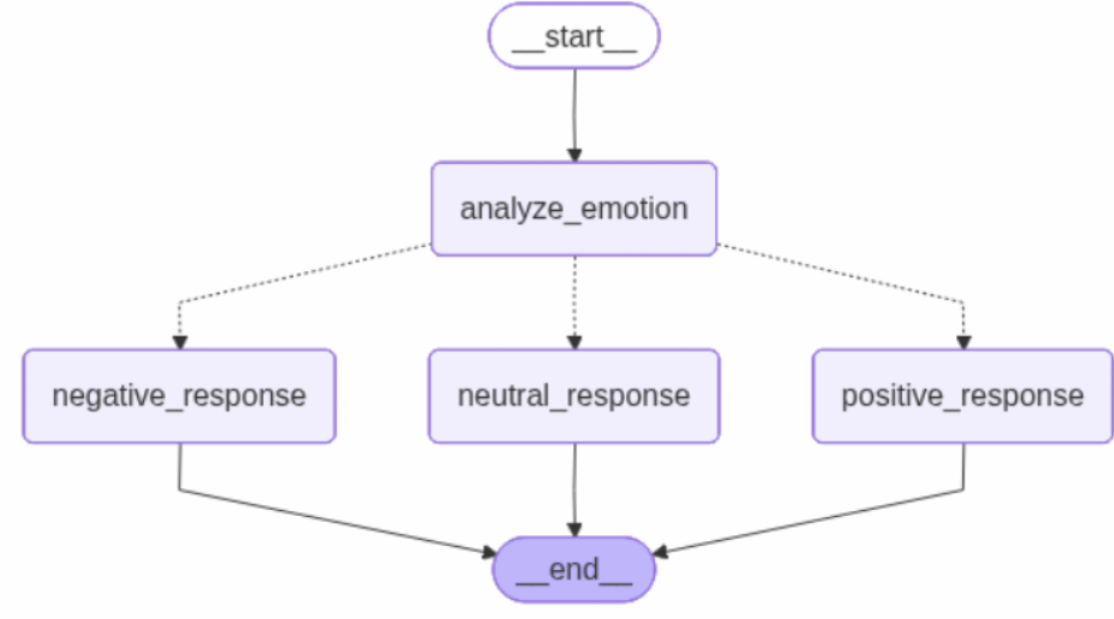

# import

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing import Dict, Any, Literal
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
import random
from IPython.display import Image, display

# 상태 정의

In [3]:
class EmotionBotState(BaseModel):
    user_message: str = Field(default="", description="사용자가 입력한 원본 메세지")
    emotion: str = Field(default="", description="분석된 감정 상태")
    response: str = Field(default="", description="최종적으로 생성된 응답 메세지")

# 모델 

In [4]:
llm = ChatOpenAI(model='gpt-4o', max_tokens=10)

# 노드 정의
LLM 기반 감정 분석 노드

In [5]:
def analyze_emotion(state: EmotionBotState) -> Dict[str, Any]:
    message = state.user_message
    print(f'LLM 감정 분석중: {message}')

    messages = [
        SystemMessage(
            content="당신은 감정 분석 전문가입니다. 사용자의 메시지를 분석하여 'positive', 'negative', 'neutral' 중 하나로 감정을 분류해주세요. 답변은 반드시 하나의 단어만 출력하세요."
        ),
        HumanMessage(content=f"다음 메시지의 감정을 분석해주세요: '{message}'"),
    ]

    response = llm.invoke(messages)
    emotion = response.content.strip().lower()
    print(f'✅모델 응답: {emotion}')

    # 유효성 검사
    if emotion not in ['positive', 'negative', 'neutral']:
        emotion = 'neutral'

    print(f'LLM 감정분석결과: {emotion}')
    return {'emotion': emotion}  # 이 값에 따라 조건부 라우팅이 될거다.



# 조건부 라우팅 함수

In [6]:
# 감정 분석 결과에 따라 '다음 노드' 결정

def route_by_emotion(state: EmotionBotState) -> Literal["positive_response", "negative_response", "neutral_response"]:
    emotion = state.emotion
    print(f'라우팅: {emotion}')

    if emotion == 'positive':
        return "positive_response"
    elif emotion == 'negative':
        return "negative_response"
    else:
        return "neutral_response"

# 응답 생성 노드들 정의

In [13]:
# 긍정 응답 생성
def generate_positive_response(state: EmotionBotState) -> Dict[str, Any]:
    responses = ["정말 좋은 소식이네요!", "기분이 좋으시군요!", "멋지네요!"]
    return {'response': random.choice(responses)}

# 부정적 응답 생성
def generate_negative_response(state: EmotionBotState) -> Dict[str, Any]:
    responses = [
        "힘든 시간이시군요. 괜찮아요.",
        "마음이 아프시겠어요.",
        "더 좋은 날이 올 거예요.",
    ]
    return {"response": random.choice(responses)}


# 중립적 응답 생성
def generate_neutral_response(state: EmotionBotState) -> Dict[str, Any]:
    responses = [
        "감사해요! 더 자세히 말씀해주세요.",
        "이해했어요. 다른 도움이 필요하시면 말씀하세요!",
        "흥미로운 주제네요!",
    ]
    return {"response": random.choice(responses)}
    

# 그래프 생성

In [14]:
def create_emotion_bot_graph():

    workflow = StateGraph(EmotionBotState)

    # 노드추가
    workflow.add_node("analyze_emotion", analyze_emotion)
    workflow.add_node("positive_response", generate_positive_response)
    workflow.add_node("negative_response", generate_negative_response)
    workflow.add_node("neutral_response", generate_neutral_response)    

    # 시작 엣지 설정
    workflow.add_edge(START, 'analyze_emotion')

    # 조건부 엣지 설정 - 동적 라우팅 구현.
    # : add_conditional_edges()는 LangGraph의 핵심 기능으로, 
    #   출발 노드 이름, 라우팅 함수, 가능한 목적지 매핑의 세 가지 인자를 받습니다. 
    #   이를 통해 런타임에 상태 기반으로 다음 실행 경로를 동적으로 결정할 수 있습니다.
    workflow.add_conditional_edges(
        "analyze_emotion",  # 출발 노드 이름
        route_by_emotion,   # 라우팅 함수
        {                   # 라우팅 함수 결과 -> 분기목적지 노드 매핑
            "positive_response": "positive_response",
            "negative_response": "negative_response",
            "neutral_response": "neutral_response",
        }
    )

    # 종료 엣지 설정
    workflow.add_edge("positive_response", END)
    workflow.add_edge("negative_response", END)
    workflow.add_edge("neutral_response", END)

    # 컴파일
    return workflow.compile()    

# 그래프 실행

== 감정 분석 챗봇 테스트===

테스트 1: "오늘 정말 기분이 좋아요!"
LLM 감정 분석중: 오늘 정말 기분이 좋아요!
✅모델 응답: positive
LLM 감정분석결과: positive
라우팅: positive
응답: 정말 좋은 소식이네요!

테스트 2: "너무 슬프고 힘들어요..."
LLM 감정 분석중: 너무 슬프고 힘들어요...
✅모델 응답: negative
LLM 감정분석결과: negative
라우팅: negative
응답: 더 좋은 날이 올 거예요.

테스트 3: "날씨가 어떤가요?"
LLM 감정 분석중: 날씨가 어떤가요?
✅모델 응답: neutral
LLM 감정분석결과: neutral
라우팅: neutral
응답: 감사해요! 더 자세히 말씀해주세요.



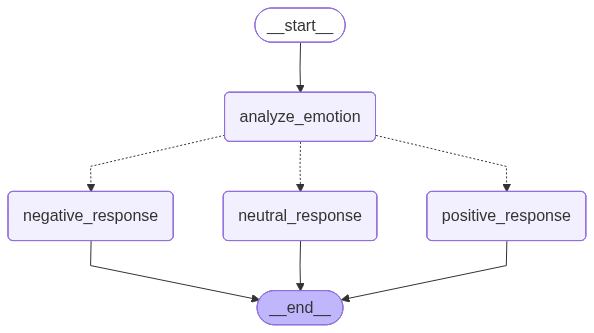

In [15]:
print("== 감정 분석 챗봇 테스트===\n")

app = create_emotion_bot_graph()

test_cases = [
    "오늘 정말 기분이 좋아요!",
    "너무 슬프고 힘들어요...",
    "날씨가 어떤가요?",
]

for i, message in enumerate(test_cases, 1):
    print(f'테스트 {i}: "{message}"')
    state = EmotionBotState(user_message=message) # 초기 상태 준비
    result = app.invoke(state)  # 리턴 값은 상태
    print(f'응답: {result['response']}\n')

# 그래프 시각화
png = app.get_graph().draw_mermaid_png()
with open("conditional_routing.png", "wb") as f:
    f.write(png)

Image('conditional_routing.png')